In [14]:
import gym
from gym import spaces
import numpy as np
import heuristicBot
import TicTacToe as ttt
import os

Player representation : 1(X), 2(O)
Game grid : a 3x3 numpy array

In [2]:
def mark_piece(grid, index, player):
    """
    1. places a move by the RL agent
    2. check if invalid
    3. if not check if agent won or draw
    4. if not place move by opponent
    5. check if opponent won or draw
    6. return respective code at appropiate step
    returns -2:continue, -1:invalid move, 
            1:1 wins, 2:2 wins, 0:draw
    """
    if grid[index] != 0:
        return -1, grid
    else:
        grid[index] = player
        score = ttt.gridScore(grid)
        if score != -1 and score == 1:
            return player, grid
        elif score != -1:
            return 0, grid
        # opponent agent : a n-step-lookahead bot
        available_moves = [(i, j) for i in range(3)
                           for j in range(3) if grid[i, j] == 0]
        opp_player = (player % 2) + 1
        opp_move_idx = heuristicBot.nslAgent(
            2, grid, available_moves, opp_player)
        grid[opp_move_idx] = opp_player
        score = ttt.gridScore(grid)
        if score != -1 and score == 1:
            return opp_player, grid
        elif score != -1:
            return 0, grid
        return -2, grid

# Defining the Custom gym environment
**Rewards**
- 1 for winning
- -1 for loosing
- -10 for invalid move
- 1/9 for everything else

In [55]:
class TicTacToeEnv(gym.Env):
    def __init__(self):
        """
        Define action and observation space
        They must be gym.spaces objects
        """
        super(TicTacToeEnv, self).__init__()
        self.action_space = spaces.Discrete(9)
        self.observation_space = spaces.Box(low=0, high=2, shape=(3,3), dtype=int)
        self.reward_range = (-10, 1)
        self.action_moves = [(i,j) for i in range(3) for j in range(3)]
        self.player = 1
        
        # defined else stable baselines throws error
        self.spec = None
        self.metadata = None


    def reset(self):
        """
        Reset the state of the environment to an initial state
        returns 
        eg.
            return self.state
        """
        self.grid = np.zeros((3, 3))

        return self.grid


    def step(self, action):
        """
        Execute one time step within the environment
        returns next state
        eg. 
            modify state
            return self.state, reward, done, info
        """
        score, self.grid = mark_piece(self.grid, self.action_moves[action], self.player)

        # reward
        reward = 0
        if score == -1:
            reward = -10
        elif score == 1:
            reward = 1
        elif score == 2:
            reward = -1
        elif score == -2:
            reward = 1/9

        # check if grid ended
        done = True
        if score == -2:
            done = False

        # info for debugginh
        info = {}
        
        return self.grid, reward, done, info


    def render(self):
        if ttt.gameOver(self.grid, self.player, False)[0]:
            print('-----------------')
            ttt.showGrid(self.grid)
            print('-----------------')


# Test environment

In [56]:
env = TicTacToeEnv()
episodes = 5
for episode in range(episodes):
    obs = env.reset()
    done = False
    score = 0

    while not done:
        env.render()
        action = env.action_space.sample()
        obs, reward, done, infp = env.step(action)
        score += reward
    print(f'Episode:{episode+1}, Score:{score}')
env.close()

Episode:1, Score:-9.777777777777779
Episode:2, Score:-0.7777777777777778
Episode:3, Score:-9.666666666666666
Episode:4, Score:-0.7777777777777778
Episode:5, Score:-9.88888888888889


In [92]:
from stable_baselines.bench import Monitor
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO2

In [108]:
# logging training information
log_dir = 'training_logs_MlpPolicy/'
os.makedirs(log_dir, exist_ok=True)

# Logging progress
monitor_env = Monitor(env, log_dir, allow_early_resets=True)

# Create a vectorized environment
vec_env = DummyVecEnv([lambda: monitor_env])

In [109]:
# using a predefined model
env = TicTacToeEnv()
pre_model = PPO2(MlpPolicy, vec_env, verbose=1)

In [110]:
pre_model.learn(total_timesteps=30000)

--------------------------------------
| approxkl           | 7.903288e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 3             |
| ep_reward_mean     | -7.21         |
| explained_variance | -0.0114       |
| fps                | 207           |
| n_updates          | 1             |
| policy_entropy     | 2.1971729     |
| policy_loss        | -0.0052517406 |
| serial_timesteps   | 128           |
| time_elapsed       | 0             |
| total_timesteps    | 128           |
| value_loss         | 29.291922     |
--------------------------------------
--------------------------------------
| approxkl           | 2.7081862e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 2.98          |
| ep_reward_mean     | -6.64         |
| explained_variance | -0.0151       |
| fps                | 296           |
| n_updates          | 2             |
| policy_entropy     | 2.1969707     |
| policy_loss        | -0.0028311445 |
| serial_timesteps   | 25

--------------------------------------
| approxkl           | 4.5234847e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 3.12          |
| ep_reward_mean     | -7.69         |
| explained_variance | -0.112        |
| fps                | 349           |
| n_updates          | 16            |
| policy_entropy     | 2.1846185     |
| policy_loss        | -0.0023792472 |
| serial_timesteps   | 2048          |
| time_elapsed       | 6.06          |
| total_timesteps    | 2048          |
| value_loss         | 12.722217     |
--------------------------------------
--------------------------------------
| approxkl           | 9.7922355e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 3.09          |
| ep_reward_mean     | -6.88         |
| explained_variance | -0.103        |
| fps                | 347           |
| n_updates          | 17            |
| policy_entropy     | 2.1857734     |
| policy_loss        | -0.004726964  |
| serial_timesteps   | 21

--------------------------------------
| approxkl           | 0.00023798412 |
| clipfrac           | 0.0           |
| ep_len_mean        | 3.29          |
| ep_reward_mean     | -5.73         |
| explained_variance | -0.017        |
| fps                | 353           |
| n_updates          | 31            |
| policy_entropy     | 2.136447      |
| policy_loss        | -0.007680476  |
| serial_timesteps   | 3968          |
| time_elapsed       | 11.6          |
| total_timesteps    | 3968          |
| value_loss         | 9.133236      |
--------------------------------------
-------------------------------------
| approxkl           | 0.0004710775 |
| clipfrac           | 0.0          |
| ep_len_mean        | 3.2          |
| ep_reward_mean     | -5.65        |
| explained_variance | -0.0438      |
| fps                | 339          |
| n_updates          | 32           |
| policy_entropy     | 2.1381252    |
| policy_loss        | -0.010019129 |
| serial_timesteps   | 4096        

--------------------------------------
| approxkl           | 0.00022842118 |
| clipfrac           | 0.0           |
| ep_len_mean        | 3.22          |
| ep_reward_mean     | -5.22         |
| explained_variance | 0.0561        |
| fps                | 154           |
| n_updates          | 46            |
| policy_entropy     | 2.0294876     |
| policy_loss        | -0.005461421  |
| serial_timesteps   | 5888          |
| time_elapsed       | 20.7          |
| total_timesteps    | 5888          |
| value_loss         | 8.549686      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00022727528 |
| clipfrac           | 0.0           |
| ep_len_mean        | 3.28          |
| ep_reward_mean     | -5.38         |
| explained_variance | 0.00741       |
| fps                | 193           |
| n_updates          | 47            |
| policy_entropy     | 2.0288134     |
| policy_loss        | -0.0074656513 |
| serial_timesteps   | 60

--------------------------------------
| approxkl           | 0.00033443864 |
| clipfrac           | 0.0           |
| ep_len_mean        | 3.14          |
| ep_reward_mean     | -3.72         |
| explained_variance | -0.0116       |
| fps                | 147           |
| n_updates          | 61            |
| policy_entropy     | 1.9251657     |
| policy_loss        | -0.009527983  |
| serial_timesteps   | 7808          |
| time_elapsed       | 31.3          |
| total_timesteps    | 7808          |
| value_loss         | 7.696969      |
--------------------------------------
-------------------------------------
| approxkl           | 0.0007587873 |
| clipfrac           | 0.0          |
| ep_len_mean        | 3.12         |
| ep_reward_mean     | -3.72        |
| explained_variance | 0.0599       |
| fps                | 183          |
| n_updates          | 62           |
| policy_entropy     | 1.9197667    |
| policy_loss        | -0.015201509 |
| serial_timesteps   | 7936        

--------------------------------------
| approxkl           | 0.00030893227 |
| clipfrac           | 0.0           |
| ep_len_mean        | 3.24          |
| ep_reward_mean     | -2.59         |
| explained_variance | 0.0183        |
| fps                | 138           |
| n_updates          | 76            |
| policy_entropy     | 1.8306177     |
| policy_loss        | -0.008465873  |
| serial_timesteps   | 9728          |
| time_elapsed       | 43.3          |
| total_timesteps    | 9728          |
| value_loss         | 5.2455397     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00042260805 |
| clipfrac           | 0.0           |
| ep_len_mean        | 3.25          |
| ep_reward_mean     | -2.29         |
| explained_variance | -0.0575       |
| fps                | 151           |
| n_updates          | 77            |
| policy_entropy     | 1.8215449     |
| policy_loss        | -0.006375794  |
| serial_timesteps   | 98

--------------------------------------
| approxkl           | 0.00040728593 |
| clipfrac           | 0.0           |
| ep_len_mean        | 3.2           |
| ep_reward_mean     | -2.31         |
| explained_variance | 0.00308       |
| fps                | 155           |
| n_updates          | 91            |
| policy_entropy     | 1.7218957     |
| policy_loss        | -0.0077437116 |
| serial_timesteps   | 11648         |
| time_elapsed       | 54.4          |
| total_timesteps    | 11648         |
| value_loss         | 4.901533      |
--------------------------------------
-------------------------------------
| approxkl           | 0.0008316068 |
| clipfrac           | 0.001953125  |
| ep_len_mean        | 3.22         |
| ep_reward_mean     | -2.29        |
| explained_variance | 0.00526      |
| fps                | 169          |
| n_updates          | 92           |
| policy_entropy     | 1.7557833    |
| policy_loss        | -0.014723059 |
| serial_timesteps   | 11776       

--------------------------------------
| approxkl           | 0.00030645824 |
| clipfrac           | 0.0           |
| ep_len_mean        | 3.2           |
| ep_reward_mean     | -2.62         |
| explained_variance | -0.00122      |
| fps                | 195           |
| n_updates          | 106           |
| policy_entropy     | 1.7057989     |
| policy_loss        | -0.002954471  |
| serial_timesteps   | 13568         |
| time_elapsed       | 65.6          |
| total_timesteps    | 13568         |
| value_loss         | 6.9354334     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00048135105 |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 3.26          |
| ep_reward_mean     | -2.51         |
| explained_variance | -0.00998      |
| fps                | 295           |
| n_updates          | 107           |
| policy_entropy     | 1.6255826     |
| policy_loss        | -0.008657416  |
| serial_timesteps   | 13

-------------------------------------
| approxkl           | 0.00038487   |
| clipfrac           | 0.0          |
| ep_len_mean        | 3.33         |
| ep_reward_mean     | -2.2         |
| explained_variance | -0.0156      |
| fps                | 166          |
| n_updates          | 121          |
| policy_entropy     | 1.596748     |
| policy_loss        | -0.008235242 |
| serial_timesteps   | 15488        |
| time_elapsed       | 76.9         |
| total_timesteps    | 15488        |
| value_loss         | 4.700209     |
-------------------------------------
--------------------------------------
| approxkl           | 0.00051331695 |
| clipfrac           | 0.0           |
| ep_len_mean        | 3.31          |
| ep_reward_mean     | -1.93         |
| explained_variance | 0.0995        |
| fps                | 281           |
| n_updates          | 122           |
| policy_entropy     | 1.6310225     |
| policy_loss        | -0.010218043  |
| serial_timesteps   | 15616         |
|

--------------------------------------
| approxkl           | 0.00049948646 |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 3.19          |
| ep_reward_mean     | -1.4          |
| explained_variance | 0.0198        |
| fps                | 143           |
| n_updates          | 136           |
| policy_entropy     | 1.5988579     |
| policy_loss        | -0.008146603  |
| serial_timesteps   | 17408         |
| time_elapsed       | 86.7          |
| total_timesteps    | 17408         |
| value_loss         | 3.1850371     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0007755605 |
| clipfrac           | 0.005859375  |
| ep_len_mean        | 3.21         |
| ep_reward_mean     | -1.38        |
| explained_variance | 0.0288       |
| fps                | 146          |
| n_updates          | 137          |
| policy_entropy     | 1.5905839    |
| policy_loss        | -0.013301512 |
| serial_timesteps   | 17536       

-------------------------------------
| approxkl           | 0.0012139423 |
| clipfrac           | 0.0078125    |
| ep_len_mean        | 3.25         |
| ep_reward_mean     | -1.69        |
| explained_variance | -0.0338      |
| fps                | 158          |
| n_updates          | 151          |
| policy_entropy     | 1.5889592    |
| policy_loss        | -0.01641624  |
| serial_timesteps   | 19328        |
| time_elapsed       | 96.9         |
| total_timesteps    | 19328        |
| value_loss         | 3.8006706    |
-------------------------------------
--------------------------------------
| approxkl           | 0.00074383075 |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 3.29          |
| ep_reward_mean     | -1.61         |
| explained_variance | 0.0647        |
| fps                | 148           |
| n_updates          | 152           |
| policy_entropy     | 1.5753795     |
| policy_loss        | -0.009363475  |
| serial_timesteps   | 19456         |
|

--------------------------------------
| approxkl           | 0.0007230705  |
| clipfrac           | 0.0078125     |
| ep_len_mean        | 3.19          |
| ep_reward_mean     | -1.98         |
| explained_variance | 0.0199        |
| fps                | 185           |
| n_updates          | 166           |
| policy_entropy     | 1.5447294     |
| policy_loss        | -0.0098406505 |
| serial_timesteps   | 21248         |
| time_elapsed       | 109           |
| total_timesteps    | 21248         |
| value_loss         | 4.5294127     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00045899226 |
| clipfrac           | 0.0           |
| ep_len_mean        | 3.22          |
| ep_reward_mean     | -1.99         |
| explained_variance | 0.0799        |
| fps                | 160           |
| n_updates          | 167           |
| policy_entropy     | 1.5609552     |
| policy_loss        | -0.007122329  |
| serial_timesteps   | 21

-------------------------------------
| approxkl           | 0.0014928697 |
| clipfrac           | 0.01953125   |
| ep_len_mean        | 3.27         |
| ep_reward_mean     | -1.86        |
| explained_variance | -0.00769     |
| fps                | 145          |
| n_updates          | 181          |
| policy_entropy     | 1.5452617    |
| policy_loss        | -0.013411621 |
| serial_timesteps   | 23168        |
| time_elapsed       | 120          |
| total_timesteps    | 23168        |
| value_loss         | 2.498206     |
-------------------------------------
--------------------------------------
| approxkl           | 0.0005795375  |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 3.19          |
| ep_reward_mean     | -1.78         |
| explained_variance | 0.0221        |
| fps                | 290           |
| n_updates          | 182           |
| policy_entropy     | 1.589509      |
| policy_loss        | -0.0105382195 |
| serial_timesteps   | 23296         |
|

-------------------------------------
| approxkl           | 0.0011265222 |
| clipfrac           | 0.0078125    |
| ep_len_mean        | 3.17         |
| ep_reward_mean     | -1.31        |
| explained_variance | -0.0141      |
| fps                | 138          |
| n_updates          | 196          |
| policy_entropy     | 1.500157     |
| policy_loss        | -0.012135681 |
| serial_timesteps   | 25088        |
| time_elapsed       | 131          |
| total_timesteps    | 25088        |
| value_loss         | 1.7722689    |
-------------------------------------
-------------------------------------
| approxkl           | 0.0004207637 |
| clipfrac           | 0.0          |
| ep_len_mean        | 3.27         |
| ep_reward_mean     | -1.16        |
| explained_variance | -0.0352      |
| fps                | 256          |
| n_updates          | 197          |
| policy_entropy     | 1.4839352    |
| policy_loss        | -0.004776948 |
| serial_timesteps   | 25216        |
| time_elaps

-------------------------------------
| approxkl           | 0.0007972666 |
| clipfrac           | 0.0078125    |
| ep_len_mean        | 3.36         |
| ep_reward_mean     | -1.21        |
| explained_variance | 0.0415       |
| fps                | 152          |
| n_updates          | 211          |
| policy_entropy     | 1.4237403    |
| policy_loss        | -0.012695135 |
| serial_timesteps   | 27008        |
| time_elapsed       | 143          |
| total_timesteps    | 27008        |
| value_loss         | 3.261669     |
-------------------------------------
--------------------------------------
| approxkl           | 0.00060856447 |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 3.35          |
| ep_reward_mean     | -0.909        |
| explained_variance | -0.654        |
| fps                | 148           |
| n_updates          | 212           |
| policy_entropy     | 1.4787536     |
| policy_loss        | -0.0101239    |
| serial_timesteps   | 27136         |
|

-------------------------------------
| approxkl           | 0.0006835769 |
| clipfrac           | 0.00390625   |
| ep_len_mean        | 3.17         |
| ep_reward_mean     | -1.41        |
| explained_variance | -0.00541     |
| fps                | 171          |
| n_updates          | 226          |
| policy_entropy     | 1.4937367    |
| policy_loss        | -0.01166134  |
| serial_timesteps   | 28928        |
| time_elapsed       | 154          |
| total_timesteps    | 28928        |
| value_loss         | 4.672463     |
-------------------------------------
-------------------------------------
| approxkl           | 0.0010323416 |
| clipfrac           | 0.01171875   |
| ep_len_mean        | 3.14         |
| ep_reward_mean     | -1.54        |
| explained_variance | 0.0452       |
| fps                | 143          |
| n_updates          | 227          |
| policy_entropy     | 1.5047895    |
| policy_loss        | -0.015378547 |
| serial_timesteps   | 29056        |
| time_elaps

# Test the model and save

In [98]:
from stable_baselines.common.evaluation import evaluate_policy

In [99]:
evaluate_policy(pre_model, env, n_eval_episodes=10, render=True)
env.close()

-----------------
| X || O || X |
| _ || O || X |
| _ || O || _ |
-----------------
-----------------
| X || O || X |
| _ || X || _ |
| O || O || X |
-----------------
-----------------
| X || O || X |
| X || O || _ |
| X || _ || O |
-----------------
-----------------
| X || O || X |
| _ || O || X |
| O || _ || X |
-----------------
-----------------
| X || O || X |
| O || X || _ |
| X || _ || O |
-----------------
-----------------
| X || O || X |
| _ || X || _ |
| O || O || X |
-----------------
-----------------
| O || X || X |
| _ || X || O |
| O || X || _ |
-----------------
-----------------
| X || O || X |
| X || O || _ |
| X || _ || O |
-----------------
-----------------
| X || O || X |
| X || O || _ |
| X || _ || O |
-----------------
-----------------
| X || X || X |
| O || O || _ |
| X || _ || O |
-----------------


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

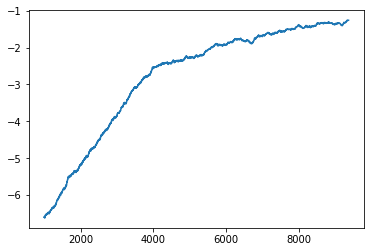

In [111]:
# Plot cumulative reward
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col=None)['r']
df.rolling(window=1000).mean().plot()
plt.show()

# Save the model

In [102]:
pre_model.save('PPO2_model')
del pre_model

In [104]:
pre_model = PPO2.load("PPO2_model", env=vec_env)

In [107]:
obs = env.reset()
while True:
    action, _states = pre_model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()
    if done:
        break
env.close()

-----------------
| O || X || X |
| _ || X || O |
| O || X || _ |
-----------------
